# Load data from kaggle

In [1]:
# ===============================
# Environment Setup
# ===============================
USE_COLAB = True

if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT = "/content/drive/MyDrive/real-and-ai-generated-synthetic-images"
else:
    PROJECT_ROOT = os.path.abspath(".")

print("PROJECT_ROOT:", PROJECT_ROOT)


Mounted at /content/drive
PROJECT_ROOT: /content/drive/MyDrive/real-and-ai-generated-synthetic-images


In [2]:
!pip install -q kagglehub

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

100%|██████████| 105M/105M [00:01<00:00, 108MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.metrics import Precision, Recall, F1Score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [5]:
train_REAL = f"{path}/train/REAL"
train_FAKE = f"{path}/train/FAKE"
test_REAL = f"{path}/test/REAL"
test_FAKE = f"{path}/test/FAKE"

In [6]:
def load_images_from_folder(folder, label, quant=1000):
    """
    Loads all images from a given folder, resizes them to 32x32,
    and assigns a specified label.
    """
    images = []
    labels = []
    if not os.path.isdir(folder):
        print(f"Warning: Directory not found at {folder}")
        return np.array([]), np.array([])
    for i,filename in enumerate(os.listdir(folder)):
        if i >= quant: break
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (32, 32))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

print("Loading training data...")
train_real_images, train_real_labels = load_images_from_folder(train_REAL, 1, quant=10000)
train_fake_images, train_fake_labels = load_images_from_folder(train_FAKE, 0, quant=10000)

print("Loading testing data...")
test_real_images, test_real_labels = load_images_from_folder(test_REAL, 1, quant=2000)
test_fake_images, test_fake_labels = load_images_from_folder(test_FAKE, 0, quant=2000)

X_train = np.concatenate((train_real_images, train_fake_images), axis=0)
y_train = np.concatenate((train_real_labels, train_fake_labels), axis=0)
X_test = np.concatenate((test_real_images, test_fake_images), axis=0)
y_test = np.concatenate((test_real_labels, test_fake_labels), axis=0)

train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Loading training data...
Loading testing data...

Training data shape: (20000, 32, 32, 3)
Testing data shape: (4000, 32, 32, 3)


# Prep train/test

In [7]:
IMG_SIZE = (32, 32)
BATCH = 32
SEED = 38

# reshape labels to 2D
y_train = y_train.astype('float32').reshape(-1, 1)  # (20000, 1)

# optional: do the same for val/test
y_test = np.asarray(y_test).astype('float32').reshape(-1, 1)

# build tf.data
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# Train

In [8]:


# y_train.reshape(-1, BATCH, 1)
# y_test.reshape(-1, BATCH, 1)
data_augment = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3)
])
model = Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    data_augment,
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")  # binary: AI(0) vs Real(1)
])


print("\nCompiling the model...")
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score(name='f1', average='micro', threshold=0.5)])
model.summary()





Compiling the model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
print("\nTraining the model...")
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    batch_size=64
)


Training the model...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 88ms/step - accuracy: 0.6171 - f1: 0.6181 - loss: 0.6433 - precision: 0.6096 - recall: 0.6305 - val_accuracy: 0.7500 - val_f1: 0.7323 - val_loss: 0.5150 - val_precision: 0.7880 - val_recall: 0.6840
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.7279 - f1: 0.7270 - loss: 0.5375 - precision: 0.7266 - recall: 0.7274 - val_accuracy: 0.7695 - val_f1: 0.7429 - val_loss: 0.4749 - val_precision: 0.8398 - val_recall: 0.6660
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.7521 - f1: 0.7476 - loss: 0.5048 - precision: 0.7585 - recall: 0.7370 - val_accuracy: 0.7705 - val_f1: 0.7334 - val_loss: 0.4557 - val_precision: 0.8747 - val_recall: 0.6315
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.7677 - f1: 0.7643 - loss: 0.4801 - precision: 0.7725 - recall: 0.7563 - val_accuracy: 0.8102 - val_f1: 0.7943 - val_loss: 0.4131 - val_precision: 0.8674 - val_recall: 0.7325
Epoch 5/1

# Result

In [10]:
print("\nEvaluating the model on the test set...")
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Loss: {results[0]:.4f}")
print(f"Final Test Accuracy: {results[1]:.4f}")
print(f"Final Test Precision: {results[2]:.4f}")
print(f"Final Test Recall: {results[3]:.4f}")
print(f"Final Test F1: {results[4]:.4f}")



Evaluating the model on the test set...
Final Test Loss: 0.4364
Final Test Accuracy: 0.7993
Final Test Precision: 0.9334
Final Test Recall: 0.6445
Final Test F1: 0.7625



--- Generating Reports and Visualizations ---
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


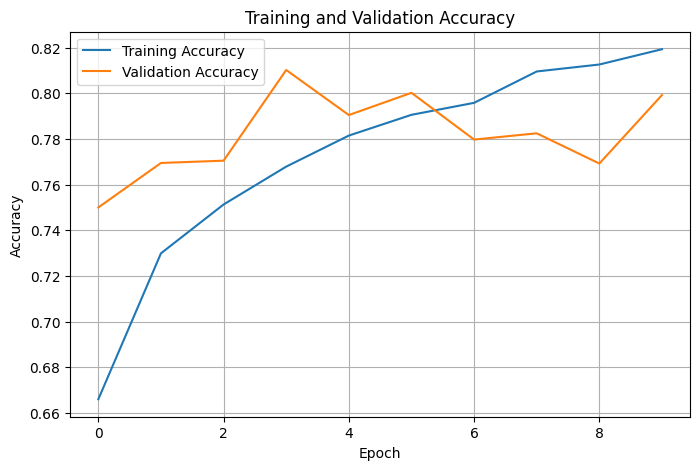

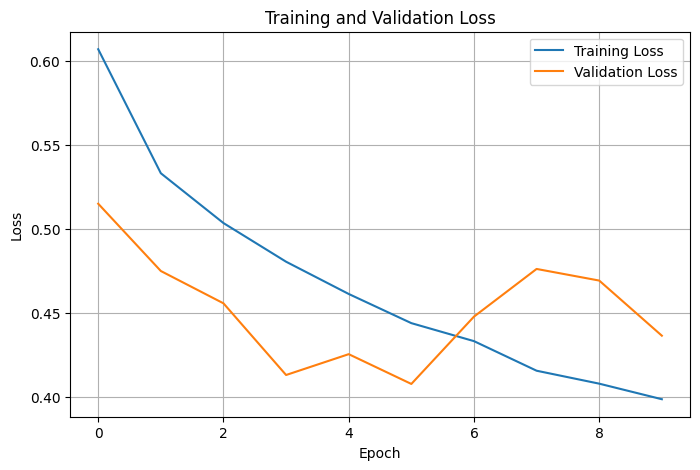

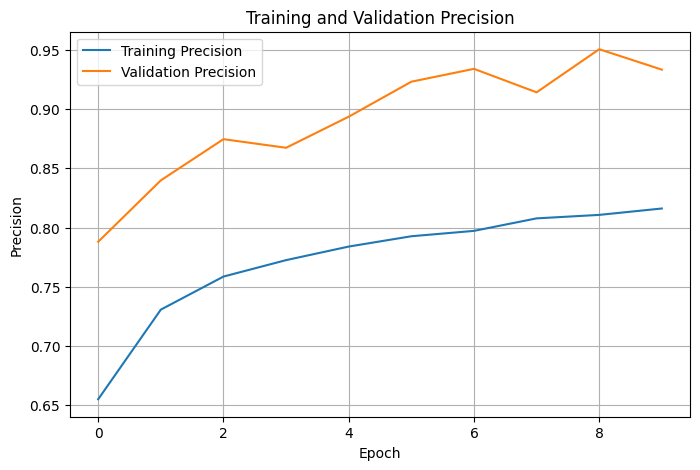

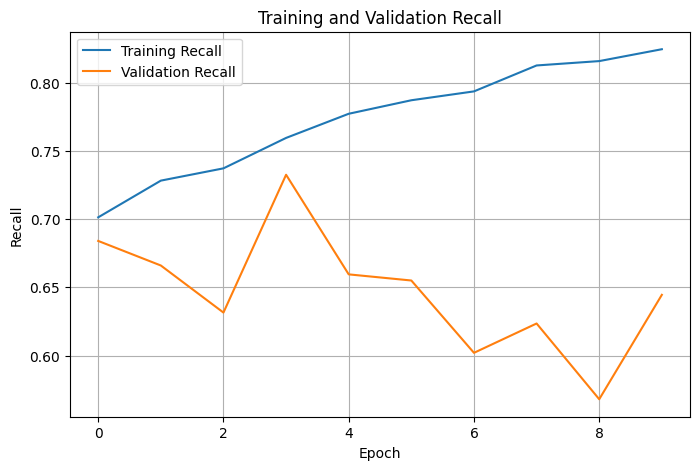

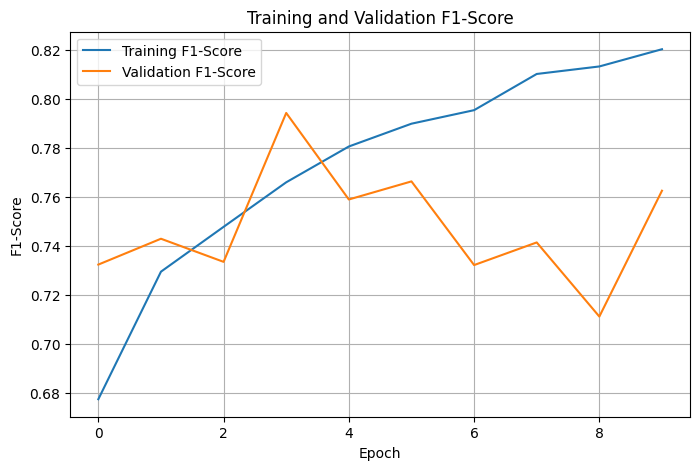


--- Classification Report ---
              precision    recall  f1-score   support

    FAKE (0)     0.7285    0.9540    0.8262      2000
    REAL (1)     0.9334    0.6445    0.7625      2000

    accuracy                         0.7993      4000
   macro avg     0.8310    0.7993    0.7943      4000
weighted avg     0.8310    0.7993    0.7943      4000


--- Confusion Matrix ---


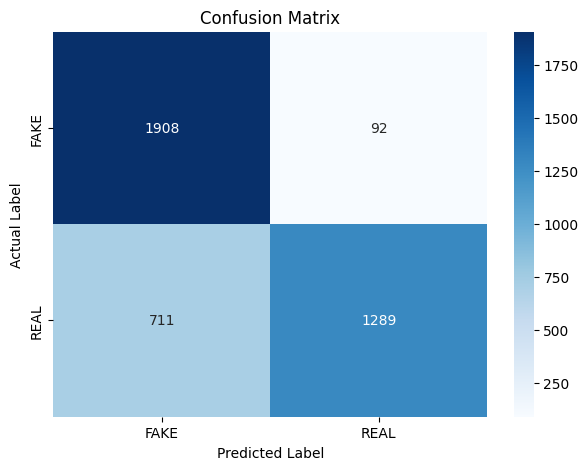


--- ROC Curve ---


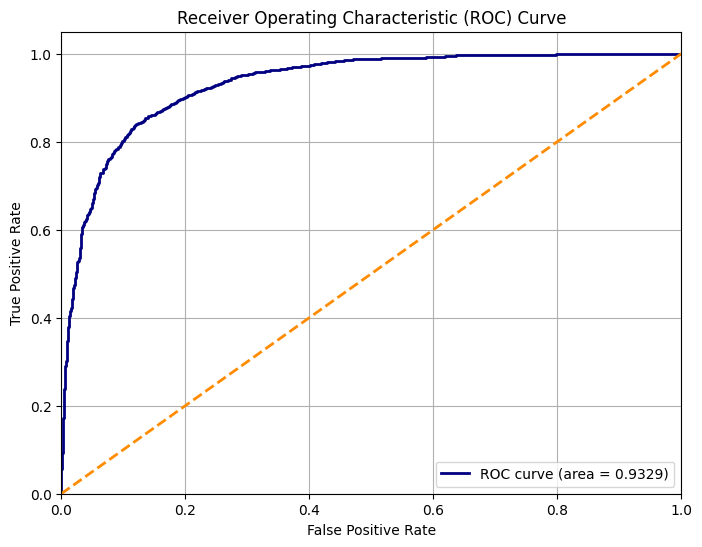

In [11]:
# 5. VISUALIZATIONS AND REPORTS
# --------------------------------------------------
print("\n--- Generating Reports and Visualizations ---")

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32")

# --- Plotting Training History ---
def plot_history(history, metric, val_metric):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
    plt.plot(history.history[val_metric], label=f'Validation {metric.capitalize()}')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history, 'accuracy', 'val_accuracy')
plot_history(history, 'loss', 'val_loss')
plot_history(history, 'precision', 'val_precision')
plot_history(history, 'recall', 'val_recall')

# --- F1-Score Plot ---
precision_train = np.array(history.history['precision'])
recall_train = np.array(history.history['recall'])
precision_val = np.array(history.history['val_precision'])
recall_val = np.array(history.history['val_recall'])

epsilon = 1e-7
f1_score_train = 2 * (precision_train * recall_train) / (precision_train + recall_train + epsilon)
f1_score_val = 2 * (precision_val * recall_val) / (precision_val + recall_val + epsilon)

plt.figure(figsize=(8, 5))
plt.plot(f1_score_train, label='Training F1-Score')
plt.plot(f1_score_val, label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.show()

# --- Classification Report ---
print("\n--- Classification Report ---")
report = classification_report(y_test, y_pred, target_names=['FAKE (0)', 'REAL (1)'], digits=4)
print(report)

# --- Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- ROC Curve and AUC ---
print("\n--- ROC Curve ---")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()